## EAPE Budget Profile

### Import package

In [13]:
import json
import numpy as np
import netCDF4 as nc

from typing import Tuple
from scipy.ndimage import convolve1d
from itertools import product
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import TwoSlopeNorm

exec(open("/home/b11209013/Package/Plot_Style.py").read())


%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


### Functions

In [14]:
# Compute stability
def compute_stability(
    lev: np.ndarray,
    theta: np.ndarray,
    density: np.ndarray,
) -> np.ndarray:

    theta_mean = theta.mean(axis=(0, -1), keepdims=True)

    density_mean = density.mean(axis=(0, -1), keepdims=True)

    theta_grad = np.gradient(theta_mean, lev * 100.0, axis=1)

    return (-theta_grad / (density_mean * theta_mean)).squeeze()[:, None]


# compute EAPE generation
def compute_generation(
    lev: np.ndarray, stab: np.ndarray, alpha: np.ndarray, heating: np.ndarray
) -> np.ndarray:
    return 287.5 * heating * alpha / (lev[:, None] * 100.0 * 1004.5 * stab)


# compute EAPE conversion
def compute_conversion(
    alpha: np.ndarray,
    omega: np.ndarray,
) -> np.ndarray:
    return alpha * omega

# compute vertical integral
def vert_int(
        lev: np.ndarray,
        data: np.ndarray,
) -> np.float64:
    print(data.shape)
    return -np.trapz(data, lev*100.0) / -np.trapz(np.ones_like(lev), lev*100.0)

### Load data

In [15]:
# Load dimensions
fpath: str = "/data92/b11209013/MPAS/merged_data"

exp_list: list[str] = ["CNTL", "NCRF"]

var_list: list[str] = ["w", "qc", "theta"]

iter_list: list[Tuple] = list(product(exp_list, var_list))

# load dimensions
with nc.Dataset(fpath + "/CNTL/theta.nc") as ds:

    dims: dict[str, np.ndarray] = {key: ds[key][:] for key in ds.dimensions.keys()}

    lat_lim: np.ndarray = np.where((dims["lat"] >= -5.0) & (dims["lat"] <= 5.0))[0]

    dims["lat"] = dims["lat"][lat_lim]

    dims["time"] = dims["time"][-360:]
    print(dims["lev"])
    converter: np.ndarray = (1000.0 / dims["lev"][None, :, None]) ** (-0.286)

print("Finished: Loading dimensions")

# Load variables
data: dict[str, dict[str, np.ndarray]] = {var: {} for var in var_list}

for exp, var in iter_list:
    with nc.Dataset(fpath + f"/{exp}/{var}.nc") as ds:
        data[var][exp] = ds[var][-360:][..., lat_lim, :].mean(axis=2)

    print(f"Finished: Loading {exp} {var}")

print("Finished: Loading data")

data["qc"] = {
    exp: data["qc"][exp] * 1004.5 / 86400  # Convert kg
    for exp in exp_list
}

# Compute specific variables
data["temp"] = {
    exp: data["theta"][exp] * converter
    for exp in exp_list
}

# Compute density
data["rho"] = {
    exp: dims["lev"][None, :, None]*100.0 / 287.5 / data["temp"][exp]
    for exp in exp_list
}

# compute omega
data["omega"] = {
    exp: -9.81 * data["rho"][exp] * data["w"][exp]
    for exp in exp_list
}

# compute alpha
data["alpha"] = {
    exp: 1 / data["rho"][exp]
    for exp in exp_list
}
var_list = data.keys()
print("Finished: Compute variables")

# Load events
with open("/home/b11209013/2025_Research/AOGS/File/events.json", "r") as f:
    events = json.load(f)

# load boundary
with open("/home/b11209013/2025_Research/AOGS/File/boundary.json", "r") as f:
    bnd = json.load(f)

[1000.  985.  965.  945.  925.  900.  875.  850.  825.  800.  775.  750.
  725.  700.  675.  650.  625.  600.  575.  550.  525.  500.  475.  450.
  425.  400.  375.  350.  325.  300.  275.  250.  225.  200.  175.  150.
  125.  100.]
Finished: Loading dimensions
Finished: Loading CNTL w
Finished: Loading CNTL qc
Finished: Loading CNTL theta
Finished: Loading NCRF w
Finished: Loading NCRF qc
Finished: Loading NCRF theta
Finished: Loading data
Finished: Compute variables


### Comute anomalies

In [16]:
anom: dict[str, dict[str, np.ndarray]] = {
    var: {
        exp: data[var][exp] -
        data[var][exp].mean(axis=(0, -1), keepdims=True)
        for exp in exp_list
    } for var in var_list
}

### Select data

In [17]:
center_idx = 360//2

sel_data: dict[str, dict[str, np.ndarray]] = {
    var: {
        exp: np.array([
            np.roll(anom[var][exp][..., x], center_idx-t, axis=0)
            for x, t in zip(events[exp]["active_x"], events[exp]["active_t"])
        ]).mean(axis=0)[center_idx+bnd[exp][0]:center_idx+bnd[exp][-1]].T
        for exp in exp_list
    }
    for var in var_list
}

print("Finished: Selecting data")

Finished: Selecting data


### Compute variables

In [18]:
# Compute stability
stab: dict[str, np.ndarray] = {
    exp: compute_stability(
        dims["lev"],
        data["theta"][exp],
        data["rho"][exp]
    ) for exp in exp_list
}

print("Finished: Computing stability")

# compute generation
gen: dict[str, np.ndarray] = {
    exp: compute_generation(
        dims["lev"],
        stab[exp],
        sel_data["alpha"][exp],
        sel_data["qc"][exp]
    ) for exp in exp_list
}

print("Finished: Computing generation")


print("Finished: Computing variance tendency")

# Compute difference in generation
gen_diff: np.ndarray = gen["NCRF"] - gen["CNTL"]


Finished: Computing stability
Finished: Computing generation
Finished: Computing variance tendency


### Plot profile

In [19]:
apply_custom_plot_style() # type: ignore

# setup dimensions
x = np.arange(bnd["CNTL"][0], bnd["CNTL"][-1], 1) / 4.0
z = dims["lev"]

z_lim = np.argmin(np.abs(z-150))+1

z = z[:z_lim]

xx, zz = np.meshgrid(x, z[:z_lim])

#### EAPE Generation

(36,)
0.00024619123268717984


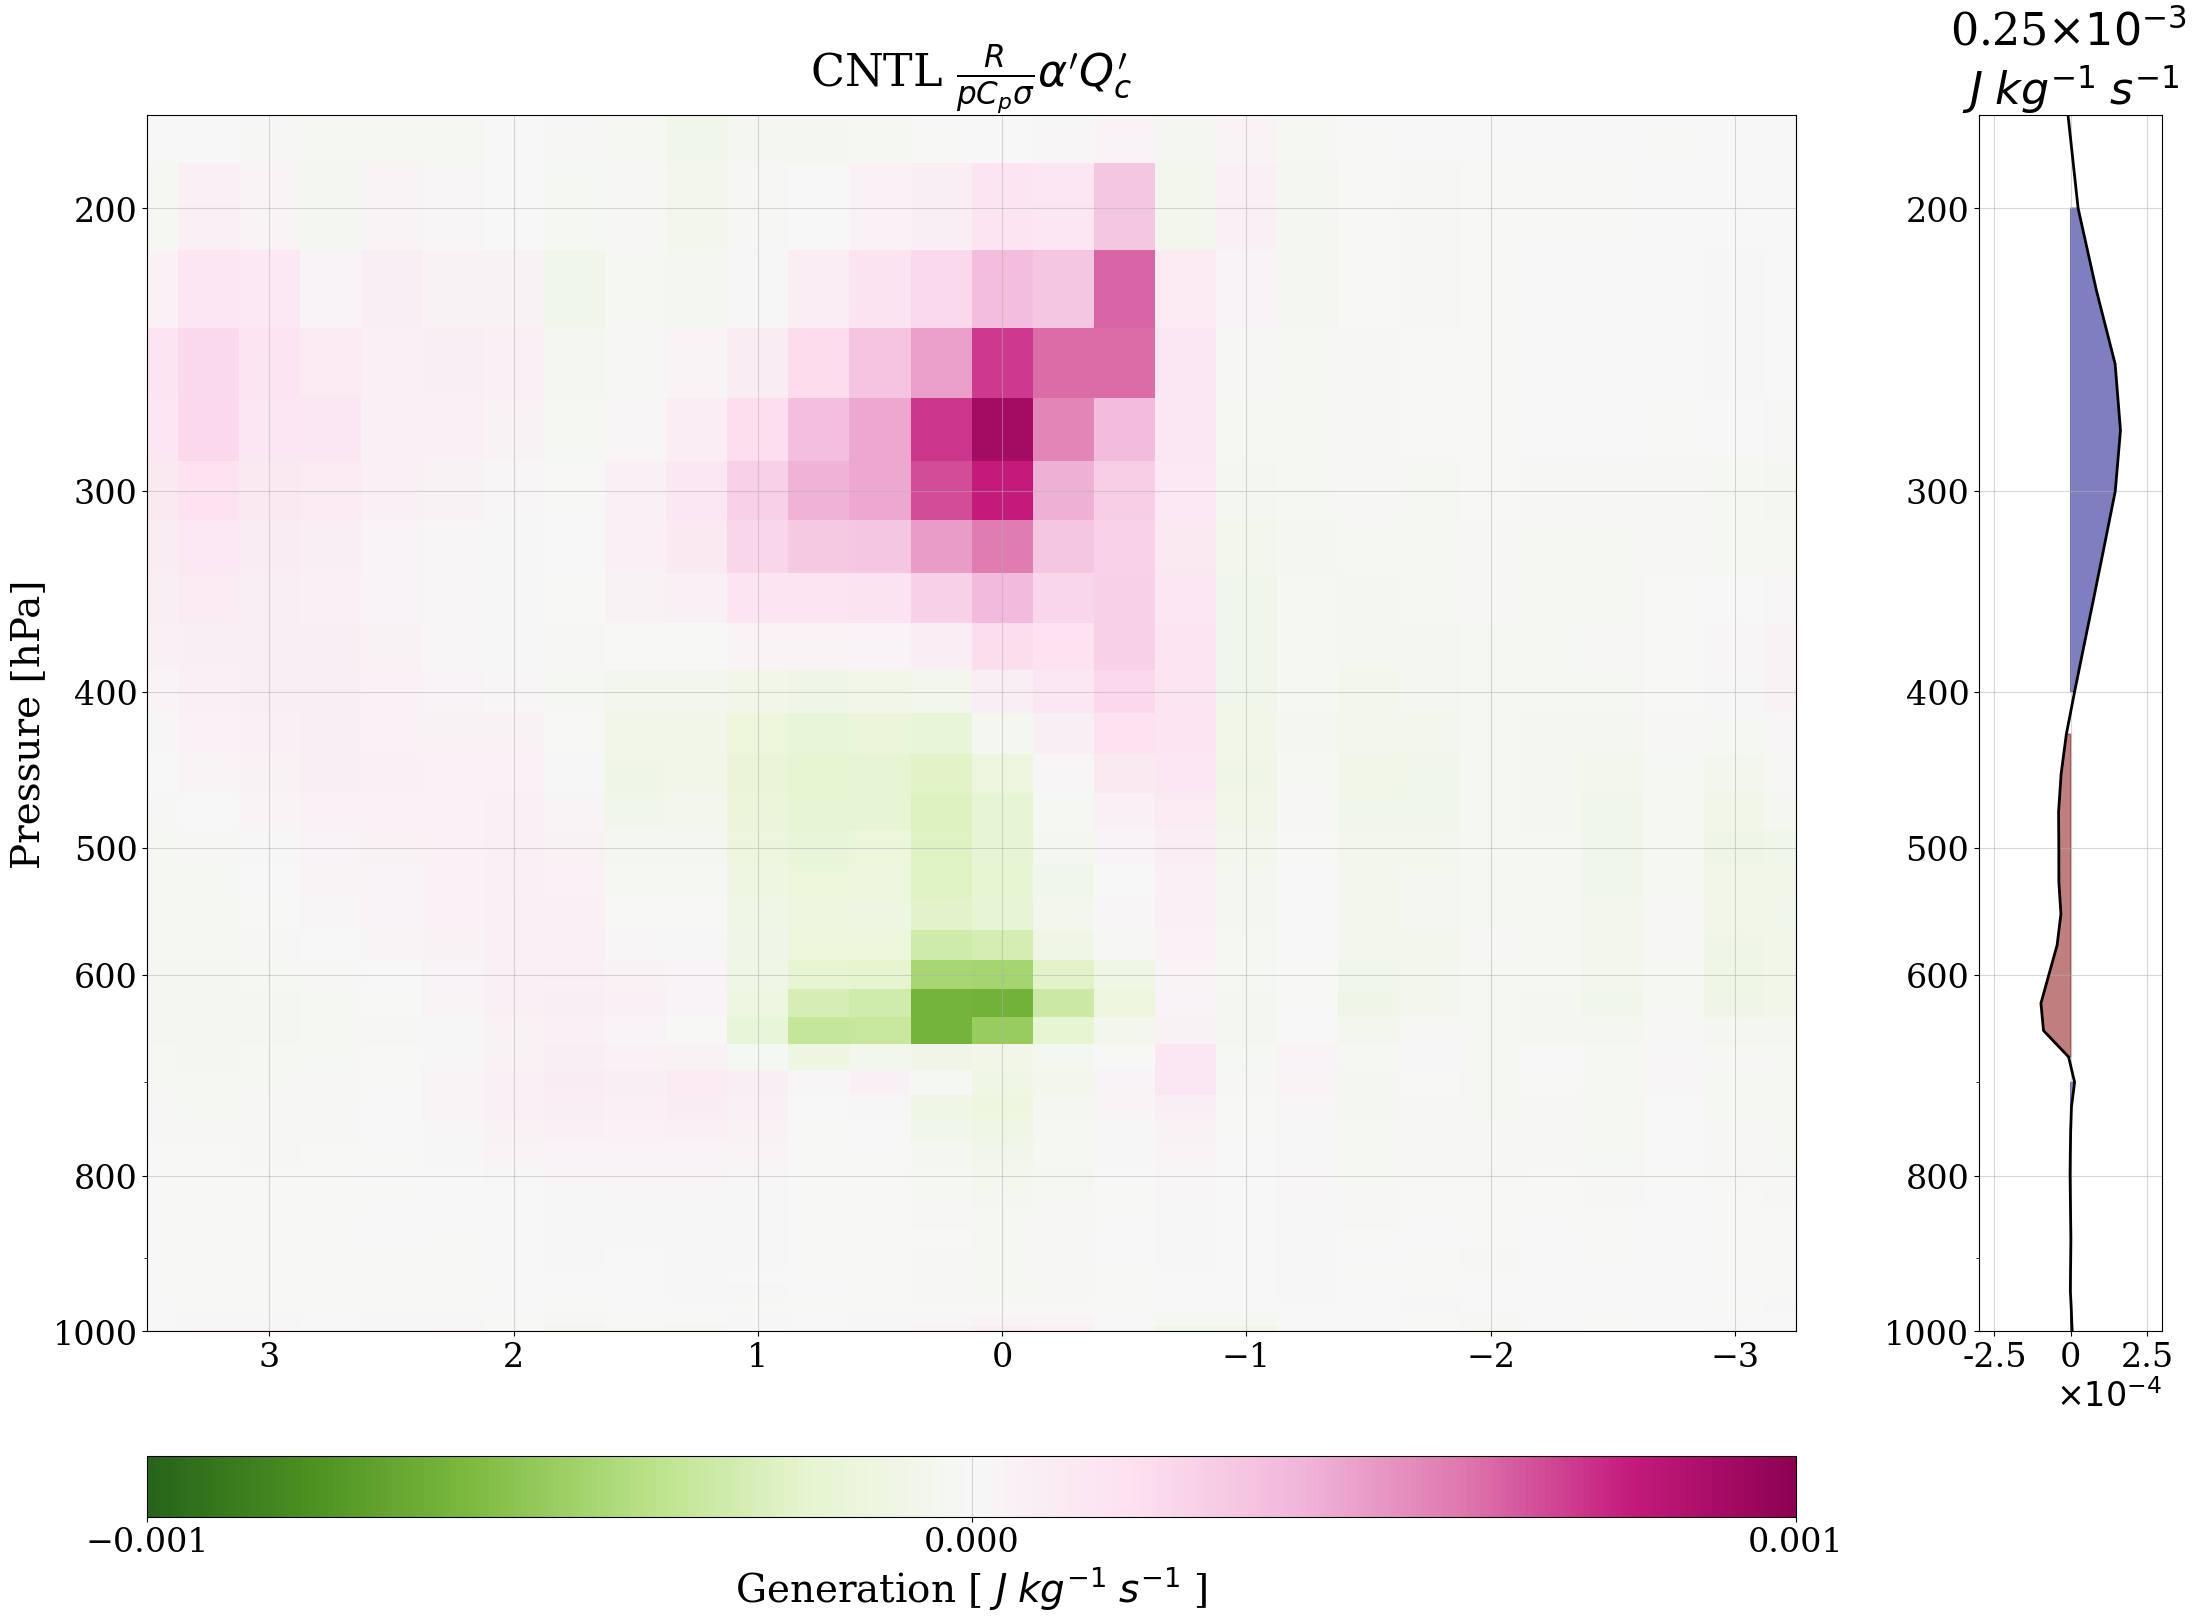

(36,)


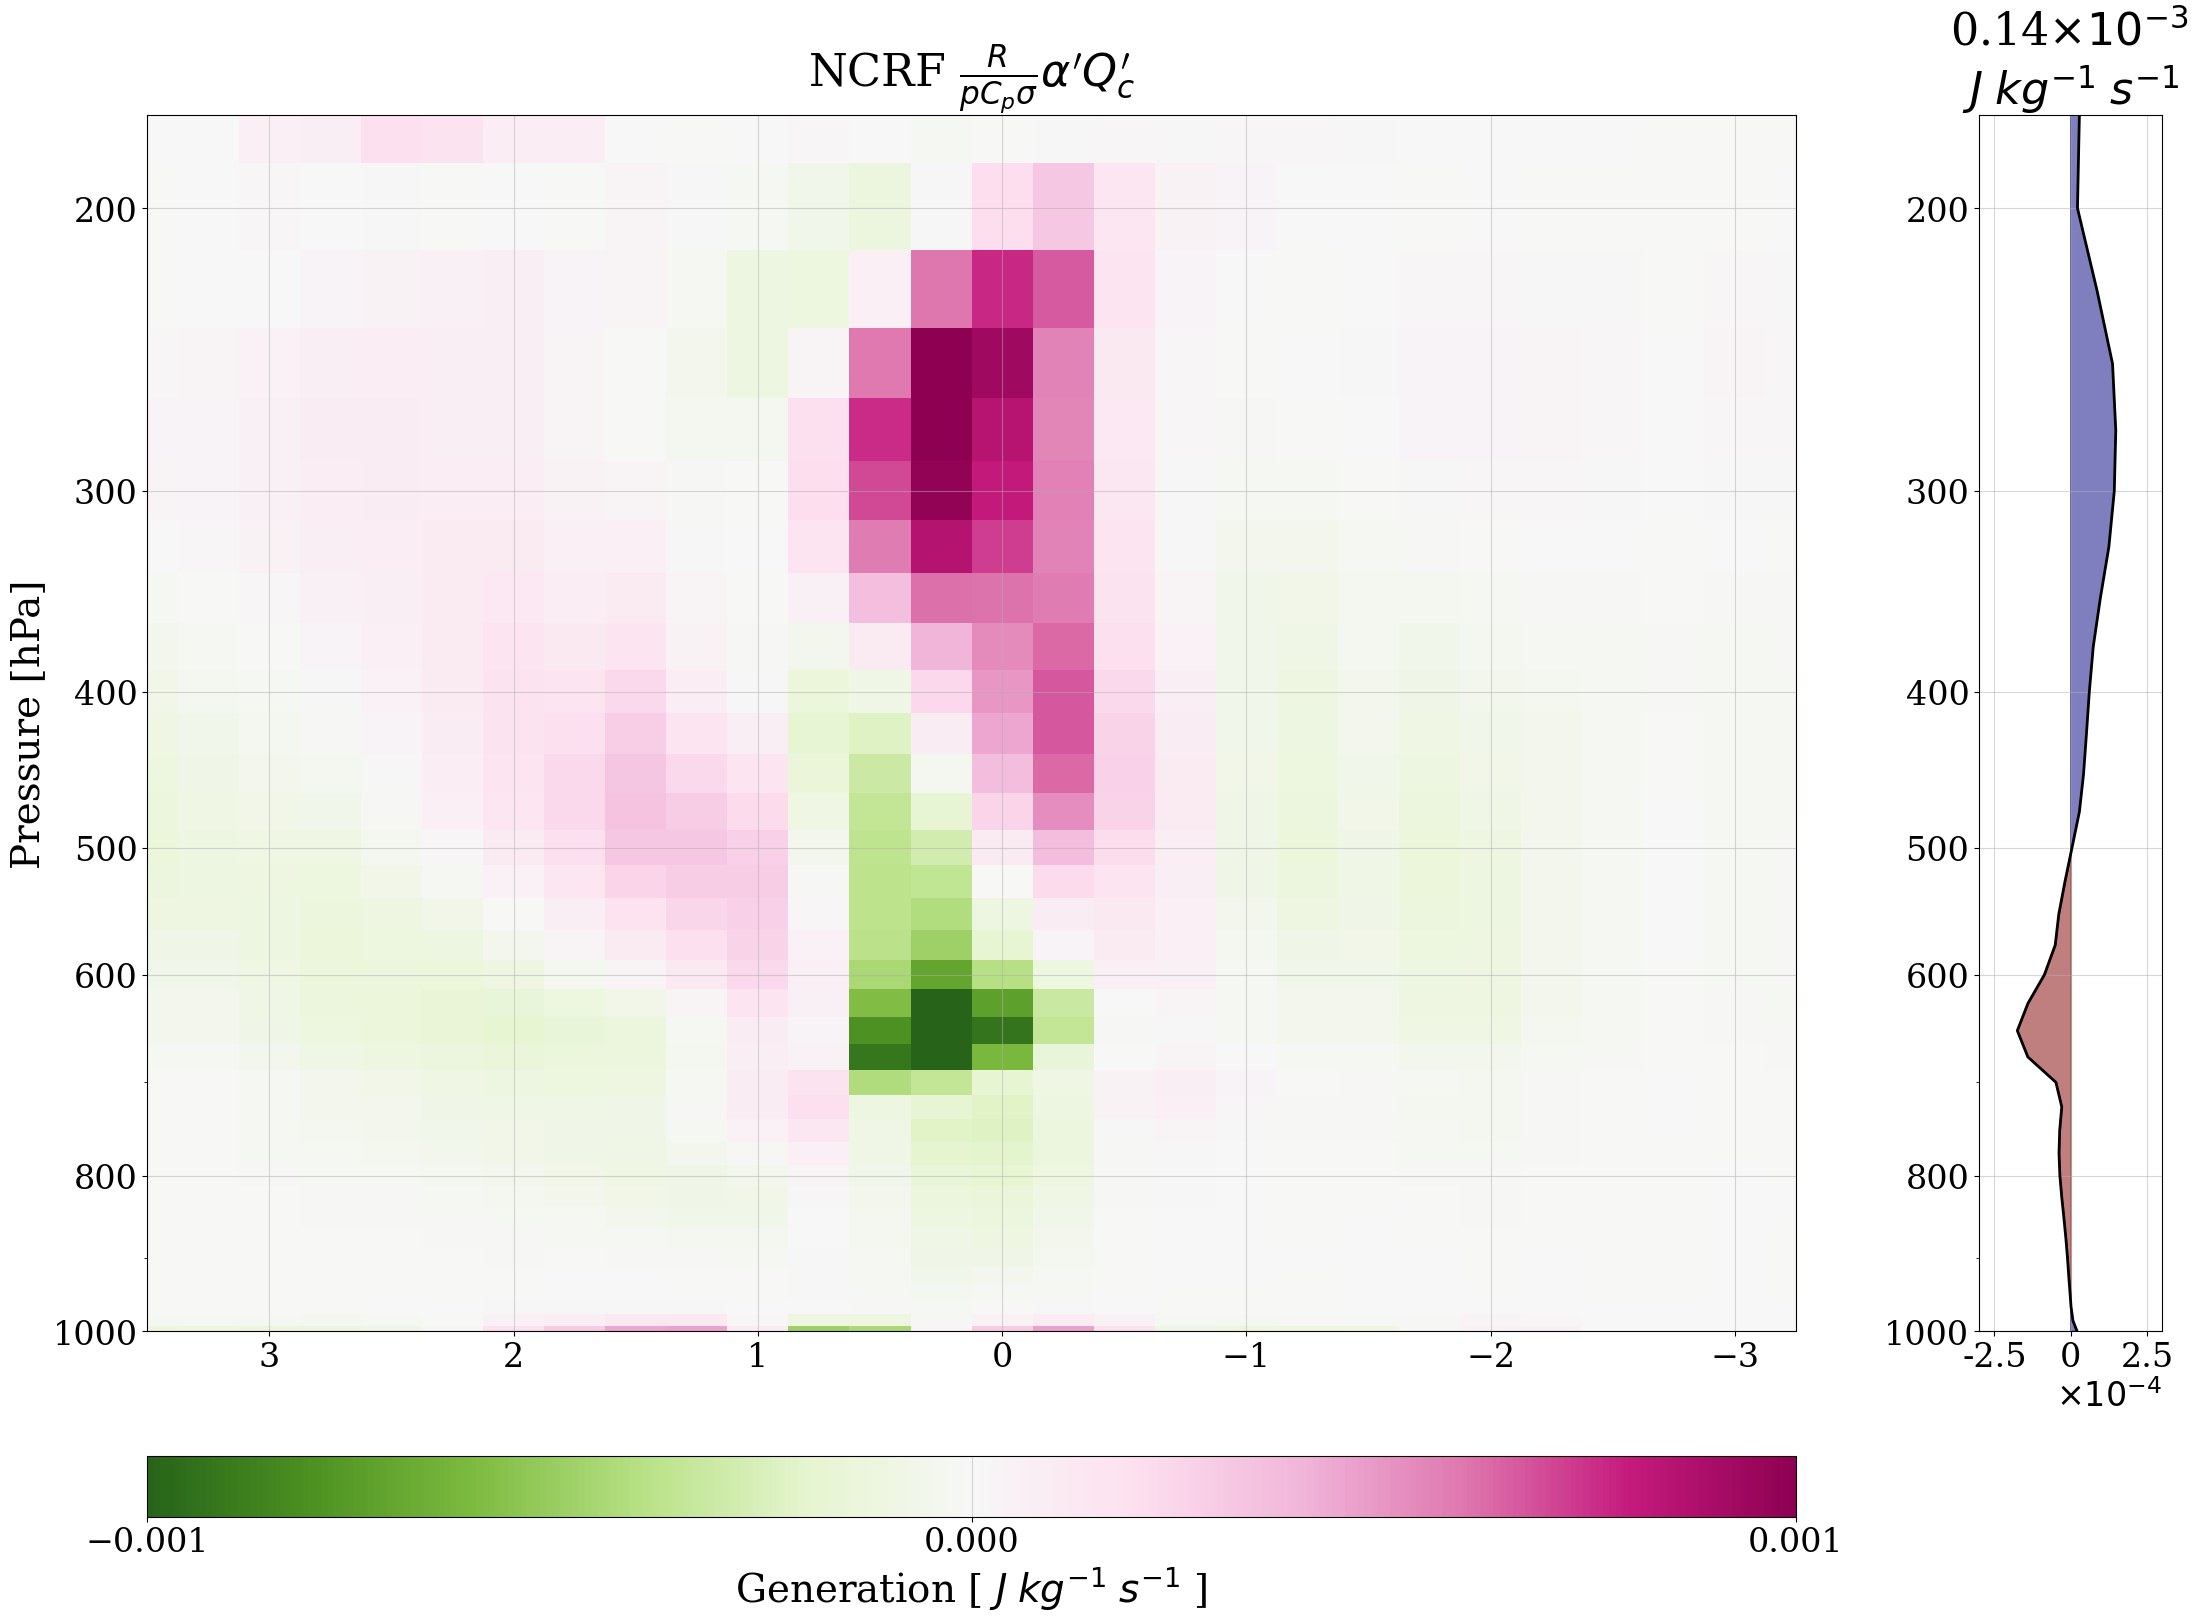

In [23]:
fig = plt.figure(figsize=(26, 17))

gs = gridspec.GridSpec(
    2, 2,
    height_ratios=[20, 1], hspace=0.05,
    width_ratios=[9, 1], wspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
c = ax1.pcolormesh(
    xx, zz,
    gen["CNTL"][:z_lim],
    cmap="PiYG_r", norm=TwoSlopeNorm(0.0, vmin=-1e-3, vmax=1e-3),
)
ax1.set_yscale("log")
ax1.set_yticks([200, 300, 400, 500, 600, 800, 1000], ["200", "300", "400", "500", "600", "800", "1000"])
ax1.set_xlim(x[-1], x[0])
ax1.set_ylim(1000, 175)
ax1.set_ylabel(r"Pressure [hPa]")
ax1.set_title(r"CNTL $\frac{R}{p C_p \sigma} \alpha^\prime Q_c^\prime$")

gen_sum = vert_int(dims["lev"][:z_lim], gen['CNTL'].sum(axis=1)[:z_lim])
print(gen_sum)
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax2.plot(gen["CNTL"].mean(axis=1)[:z_lim], z, color="k", linewidth=2)
ax2.fill_betweenx(z, 0, gen["CNTL"].mean(axis=1)[:z_lim], where=gen["CNTL"].mean(axis=1)[:z_lim] > 0, color="navy", alpha=0.5)
ax2.fill_betweenx(z, gen["CNTL"].mean(axis=1)[:z_lim], 0, where=gen["CNTL"].mean(axis=1)[:z_lim] < 0, color="maroon", alpha=0.5)
ax2.set_xticks(np.linspace(-2.5e-4, 2.5e-4, 3), ["-2.5", "0", "2.5"])
ax2.set_xlim(-3e-4, 3e-4)
ax2.set_ylim(1000, 175)
ax2.set_xlabel(r"$\times 10^{-4}$", fontsize=24, loc="right")
ax2.set_title(f"{gen_sum*1e3:.2f}"+r"$\times 10^{-3}$"+" \n"+r"$J\;kg^{-1}\;s^{-1}$")

ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(
    c, cax=ax_cb, orientation='horizontal',
    label=r"Generation [ $J\;kg^{-1}\;s^{-1}$ ]",
    ticks=np.linspace(-1e-3, 1e-3, 3)
    )
    
bbox_main = ax1.get_position()
bbox_cb = ax_cb.get_position()
dy = bbox_main.y0 - bbox_cb.y0
ax_cb.set_position((bbox_cb.x0, bbox_cb.y0 - dy, bbox_cb.width, bbox_cb.height))

plt.savefig("/home/b11209013/2025_Research/AOGS/Figure/EAPE/Qc_Generation/CNTL.png", dpi=300)
plt.show()
plt.close(fig)

fig = plt.figure(figsize=(26, 17))

gs = gridspec.GridSpec(
    2, 2,
    height_ratios=[20, 1], hspace=0.05,
    width_ratios=[9, 1], wspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
c = ax1.pcolormesh(
    xx, zz,
    gen["NCRF"][:z_lim],
    cmap="PiYG_r", norm=TwoSlopeNorm(0.0, vmin=-1e-3, vmax=1e-3),
)
ax1.set_yscale("log")
ax1.set_yticks([200, 300, 400, 500, 600, 800, 1000], ["200", "300", "400", "500", "600", "800", "1000"])
ax1.set_xlim(x[-1], x[0])
ax1.set_ylim(1000, 175)
ax1.set_ylabel(r"Pressure [hPa]")
ax1.set_title(r"NCRF $\frac{R}{p C_p \sigma} \alpha^\prime Q_c^\prime$")

gen_sum = vert_int(dims["lev"][:z_lim], gen['NCRF'].sum(axis=1)[:z_lim])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax2.plot(gen["NCRF"].mean(axis=1)[:z_lim], z, color="k", linewidth=2)
ax2.fill_betweenx(
    z, 0, gen["NCRF"].mean(axis=1)[:z_lim],
    where=gen["NCRF"].mean(axis=1)[:z_lim] >= 0,
    color="navy", alpha=0.5, interpolate=True)
ax2.fill_betweenx(
    z, gen["NCRF"].mean(axis=1)[:z_lim], 0,
    where=gen["NCRF"].mean(axis=1)[:z_lim] <= 0,
    color="maroon", alpha=0.5, interpolate=True)
ax2.set_xticks(np.linspace(-2.5e-4, 2.5e-4, 3), ["-2.5", "0", "2.5"])
ax2.set_xlim(-3e-4, 3e-4)
ax2.set_ylim(1000, 175)
ax2.set_xlabel(r"$\times 10^{-4}$", fontsize=24, loc="right")
ax2.set_title(f"{gen_sum*1e3:.2f}"+r"$\times 10^{-3}$"+" \n"+r"$J\;kg^{-1}\;s^{-1}$")

ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(
    c, cax=ax_cb, orientation='horizontal',
    label=r"Generation [ $J\;kg^{-1}\;s^{-1}$ ]",
    ticks=np.linspace(-0.001, 0.001, 3)
    )
    
bbox_main = ax1.get_position()
bbox_cb = ax_cb.get_position()
dy = bbox_main.y0 - bbox_cb.y0
ax_cb.set_position((bbox_cb.x0, bbox_cb.y0 - dy, bbox_cb.width, bbox_cb.height))

plt.savefig("/home/b11209013/2025_Research/AOGS/Figure/EAPE/Qc_Generation/NCRF.png", dpi=300)
plt.show()
plt.close(fig)
